In [1]:
%%html
<style>
    #notebook-container{
    width: 100%
    }
</style>

In [2]:
import numpy as np #importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats as sm_stat

from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn import linear_model
from sklearn import model_selection
from scipy import stats

sns.set()

In [3]:
# telco_df = pd.read_csv('telco.txt', sep='\t') #load dataset
telco_df = pd.read_csv('https://raw.githubusercontent.com/kai-wren/Statistic/master/telco.txt', sep='\t') #load dataset
telco_df.head()

,tenure,age,marital,address,income,ed,employ,retire,gender,longmon,wiremon,churn
1,13,44,Married,9,64,College degree,5,No,Male,3.70,0.0,Yes
2,11,33,Married,7,136,Post-undergraduate degree,5,No,Male,4.40,35.7,Yes
3,68,52,Married,24,116,Did not complete high school,29,No,Female,18.15,0.0,No
4,33,33,Unmarried,12,33,High school degree,0,No,Female,9.45,0.0,Yes
5,23,30,Married,9,30,Did not complete high school,2,No,Male,6.30,0.0,No


# Problem 6: Regression techniques

In this problem we use the same data set on service usage of 1000 clients of a telecommunication company as in Assignment 2. The variable "tenure" is taken as the dependent variable and the remaining variables as explanatory. <br>

## Subtask 1.

The lasso regression is an alternative approach to variable selection. <br>

### Part (a)
Explain in your own words the idea of the lasso regression. Sketch a situation when a simple linear regression fails, but the lasso regression still can be estimated.

### Part (b)

For the usual regression model the variables are rarely normalized/standardized. However, in the case of the lasso regression the scaling becomes crucial. Why? Scale your data by $(x_i - \bar x)/\hat \sigma_x$. Can/should the binary variables be scaled in the same fashion? How would you handle the variable "ed"?

For Lasso regression scaling of data become crucial because independent variables should be centered around 0 (have mean of 0). Because of this reason we perform scaling of data as per formula $\frac{(x_i - \bar x)}{\hat \sigma_x}$. Without scaling Lasso regression would provide a wrong results - countours of Least Square solution will intersect with non-scaled data in different points than it should. <br>

As for binary variables - those should be scaled as well. Otherwise for such variables like "gender" mean value will be around 0.5 and not 0 as it should be. Same holds for other binary variables - mean value is not equal to 0 as result Lasso regression will produce wrong results. Hence, I am also scaling all dummy variables to center those around mean of 0. <br>

For variable "ed", in addition to scaling, we also need to group all education related dummy variables and perform group Lasso regression which keeps related dummy variables as single group. In such case either none or all of such variables are excluded. Grouped dummy variables could not be excluded partially.

In [4]:
telco_df_norm = telco_df.copy() #normalizing data

telco_df_norm.tenure = (telco_df_norm.tenure-telco_df_norm.tenure.mean()) / telco_df_norm.tenure.std()
telco_df_norm.age = (telco_df_norm.age-telco_df_norm.age.mean()) / telco_df_norm.age.std()
telco_df_norm.address = (telco_df_norm.address-telco_df_norm.address.mean()) / telco_df_norm.address.std()
telco_df_norm.income = (telco_df_norm.income-telco_df_norm.income.mean()) / telco_df_norm.income.std()
telco_df_norm.employ = (telco_df_norm.employ-telco_df_norm.employ.mean()) / telco_df_norm.employ.std()
telco_df_norm.longmon = (telco_df_norm.longmon-telco_df_norm.longmon.mean()) / telco_df_norm.longmon.std()
telco_df_norm.wiremon = (telco_df_norm.wiremon-telco_df_norm.wiremon.mean()) / telco_df_norm.wiremon.std()

telco_df_norm.describe()

,tenure,age,address,income,employ,longmon,wiremon
count,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03
mean,-1.503242e-16,2.208789e-16,-3.130829e-17,1.431633e-16,-1.676437e-17,-1.427414e-15,3.501643e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.616400e+00,-1.885847e+00,-1.145173e+00,-6.402498e-01,-1.089755e+00,-1.044349e+00,-5.874360e-01
25%,-8.673297e-01,-7.710918e-01,-8.477516e-01,-4.534110e-01,-7.921971e-01,-6.294310e-01,-5.874360e-01
50%,-7.144258e-02,-1.340891e-01,-2.529078e-01,-2.852561e-01,-2.962680e-01,-3.085931e-01,-5.874360e-01
75%,8.648953e-01,7.417897e-01,6.393580e-01,5.105369e-02,5.964043e-01,2.595073e-01,6.657699e-01
max,1.707599e+00,2.812048e+00,4.307561e+00,1.485803e+01,3.571979e+00,8.513245e+00,5.089707e+00


In [5]:
telco_df_norm_dummy = telco_df_norm.copy()

telco_df_norm_dummy = pd.get_dummies(telco_df_norm, columns=(['marital', 'retire', 'gender', 'churn', 'ed']))

telco_df_norm_dummy.drop(columns=(['marital_Unmarried', 'retire_No', 'gender_Female', 'churn_No', 
                                               'ed_Post-undergraduate degree']), inplace=True)
telco_df_norm_dummy.rename(columns={'marital_Married': 'marital_dummy', 'retire_Yes': 'retire_dummy', 
                               'gender_Male': 'gender_dummy', 'churn_Yes': 'churn_dummy', 
                              'ed_College degree': 'ed_dummy_college_degree', 
                               'ed_Did not complete high school': 'ed_dummy_no_high_school',
                              'ed_High school degree': 'ed_dummy_high_school',
                              'ed_Some college': 'ed_dummy_some_college'}, inplace=True)

telco_df_norm_dummy.marital_dummy = (telco_df_norm_dummy.marital_dummy-telco_df_norm_dummy.marital_dummy.mean()) / telco_df_norm_dummy.marital_dummy.std()
telco_df_norm_dummy.retire_dummy = (telco_df_norm_dummy.retire_dummy-telco_df_norm_dummy.retire_dummy.mean()) / telco_df_norm_dummy.retire_dummy.std()
telco_df_norm_dummy.gender_dummy = (telco_df_norm_dummy.gender_dummy-telco_df_norm_dummy.gender_dummy.mean()) / telco_df_norm_dummy.gender_dummy.std()
telco_df_norm_dummy.churn_dummy = (telco_df_norm_dummy.churn_dummy-telco_df_norm_dummy.churn_dummy.mean()) / telco_df_norm_dummy.churn_dummy.std()
telco_df_norm_dummy.ed_dummy_college_degree = (telco_df_norm_dummy.ed_dummy_college_degree-telco_df_norm_dummy.ed_dummy_college_degree.mean()) / telco_df_norm_dummy.ed_dummy_college_degree.std()
telco_df_norm_dummy.ed_dummy_no_high_school = (telco_df_norm_dummy.ed_dummy_no_high_school-telco_df_norm_dummy.ed_dummy_no_high_school.mean()) / telco_df_norm_dummy.ed_dummy_no_high_school.std()
telco_df_norm_dummy.ed_dummy_high_school = (telco_df_norm_dummy.ed_dummy_high_school-telco_df_norm_dummy.ed_dummy_high_school.mean()) / telco_df_norm_dummy.ed_dummy_high_school.std()
telco_df_norm_dummy.ed_dummy_some_college = (telco_df_norm_dummy.ed_dummy_some_college-telco_df_norm_dummy.ed_dummy_some_college.mean()) / telco_df_norm_dummy.ed_dummy_some_college.std()

telco_df_norm_dummy.describe()

,tenure,age,address,income,employ,longmon,wiremon,marital_dummy,retire_dummy,gender_dummy,churn_dummy,ed_dummy_college_degree,ed_dummy_no_high_school,ed_dummy_high_school,ed_dummy_some_college
count,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03
mean,-1.503242e-16,2.208789e-16,-3.130829e-17,1.431633e-16,-1.676437e-17,-1.427414e-15,3.501643e-16,9.992007e-17,-1.318390e-16,-2.435829e-16,6.616929e-17,-8.992806e-17,-1.403322e-16,1.296740e-16,1.183498e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.616400e+00,-1.885847e+00,-1.145173e+00,-6.402498e-01,-1.089755e+00,-1.044349e+00,-5.874360e-01,-9.895544e-01,-2.219654e-01,-9.660754e-01,-6.140302e-01,-5.524288e-01,-5.059893e-01,-6.341309e-01,-5.137687e-01
25%,-8.673297e-01,-7.710918e-01,-8.477516e-01,-4.534110e-01,-7.921971e-01,-6.294310e-01,-5.874360e-01,-9.895544e-01,-2.219654e-01,-9.660754e-01,-6.140302e-01,-5.524288e-01,-5.059893e-01,-6.341309e-01,-5.137687e-01
50%,-7.144258e-02,-1.340891e-01,-2.529078e-01,-2.852561e-01,-2.962680e-01,-3.085931e-01,-5.874360e-01,-9.895544e-01,-2.219654e-01,-9.660754e-01,-6.140302e-01,-5.524288e-01,-5.059893e-01,-6.341309e-01,-5.137687e-01
75%,8.648953e-01,7.417897e-01,6.393580e-01,5.105369e-02,5.964043e-01,2.595073e-01,6.657699e-01,1.009545e+00,-2.219654e-01,1.034081e+00,1.626956e+00,-5.524288e-01,-5.059893e-01,1.575384e+00,-5.137687e-01
max,1.707599e+00,2.812048e+00,4.307561e+00,1.485803e+01,3.571979e+00,8.513245e+00,5.089707e+00,1.009545e+00,4.500702e+00,1.034081e+00,1.626956e+00,1.808378e+00,1.974350e+00,1.575384e+00,1.944455e+00


### Part (c)

Run a lasso regression for data with $\lambda \in (0, 1)$. Plot the estimated parameters as functions of $\lambda$. Which value of $\lambda$ would you recommend? If it is easy to implement, then determine the optimal $\lambda$ by cross-validation.

For alpha=0.80000
Training score: 0.00000
Test score: -0.02047
Number of features used: 0 

For alpha=0.79900
Training score: 0.00000
Test score: -0.02047
Number of features used: 0 

For alpha=0.79800
Training score: 0.00000
Test score: -0.02047
Number of features used: 0 

For alpha=0.79700
Training score: 0.00000
Test score: -0.02047
Number of features used: 0 

For alpha=0.79600
Training score: 0.00000
Test score: -0.02047
Number of features used: 0 

For alpha=0.79500
Training score: 0.00000
Test score: -0.02047
Number of features used: 0 

For alpha=0.79400
Training score: 0.00000
Test score: -0.02047
Number of features used: 0 

For alpha=0.79300
Training score: 0.00000
Test score: -0.02047
Number of features used: 0 

For alpha=0.79200
Training score: 0.00000
Test score: -0.02047
Number of features used: 0 

For alpha=0.79100
Training score: 0.00000
Test score: -0.02047
Number of features used: 0 

For alpha=0.79000
Training score: 0.00000
Test score: -0.02047
Number of feature

For alpha=0.69600
Training score: 0.05592
Test score: 0.02976
Number of features used: 1 

For alpha=0.69500
Training score: 0.05719
Test score: 0.03091
Number of features used: 1 

For alpha=0.69400
Training score: 0.05847
Test score: 0.03206
Number of features used: 1 

For alpha=0.69300
Training score: 0.05974
Test score: 0.03321
Number of features used: 1 

For alpha=0.69200
Training score: 0.06100
Test score: 0.03435
Number of features used: 1 

For alpha=0.69100
Training score: 0.06227
Test score: 0.03550
Number of features used: 1 

For alpha=0.69000
Training score: 0.06353
Test score: 0.03664
Number of features used: 1 

For alpha=0.68900
Training score: 0.06480
Test score: 0.03779
Number of features used: 1 

For alpha=0.68800
Training score: 0.06606
Test score: 0.03893
Number of features used: 1 

For alpha=0.68700
Training score: 0.06731
Test score: 0.04007
Number of features used: 1 

For alpha=0.68600
Training score: 0.06857
Test score: 0.04121
Number of features used: 1 


For alpha=0.58800
Training score: 0.18284
Test score: 0.14664
Number of features used: 1 

For alpha=0.58700
Training score: 0.18392
Test score: 0.14765
Number of features used: 1 

For alpha=0.58600
Training score: 0.18499
Test score: 0.14866
Number of features used: 1 

For alpha=0.58500
Training score: 0.18606
Test score: 0.14967
Number of features used: 1 

For alpha=0.58400
Training score: 0.18713
Test score: 0.15068
Number of features used: 1 

For alpha=0.58300
Training score: 0.18820
Test score: 0.15168
Number of features used: 1 

For alpha=0.58200
Training score: 0.18927
Test score: 0.15269
Number of features used: 1 

For alpha=0.58100
Training score: 0.19033
Test score: 0.15369
Number of features used: 1 

For alpha=0.58000
Training score: 0.19140
Test score: 0.15470
Number of features used: 1 

For alpha=0.57900
Training score: 0.19246
Test score: 0.15570
Number of features used: 1 

For alpha=0.57800
Training score: 0.19352
Test score: 0.15670
Number of features used: 1 


For alpha=0.48300
Training score: 0.28577
Test score: 0.24585
Number of features used: 1 

For alpha=0.48200
Training score: 0.28665
Test score: 0.24672
Number of features used: 1 

For alpha=0.48100
Training score: 0.28754
Test score: 0.24760
Number of features used: 1 

For alpha=0.48000
Training score: 0.28841
Test score: 0.24847
Number of features used: 1 

For alpha=0.47900
Training score: 0.28929
Test score: 0.24934
Number of features used: 1 

For alpha=0.47800
Training score: 0.29017
Test score: 0.25022
Number of features used: 1 

For alpha=0.47700
Training score: 0.29104
Test score: 0.25109
Number of features used: 1 

For alpha=0.47600
Training score: 0.29191
Test score: 0.25195
Number of features used: 1 

For alpha=0.47500
Training score: 0.29279
Test score: 0.25282
Number of features used: 1 

For alpha=0.47400
Training score: 0.29365
Test score: 0.25369
Number of features used: 1 

For alpha=0.47300
Training score: 0.29452
Test score: 0.25455
Number of features used: 1 


For alpha=0.37000
Training score: 0.37399
Test score: 0.33672
Number of features used: 1 

For alpha=0.36900
Training score: 0.37467
Test score: 0.33746
Number of features used: 1 

For alpha=0.36800
Training score: 0.37534
Test score: 0.33819
Number of features used: 1 

For alpha=0.36700
Training score: 0.37602
Test score: 0.33891
Number of features used: 1 

For alpha=0.36600
Training score: 0.37669
Test score: 0.33964
Number of features used: 1 

For alpha=0.36500
Training score: 0.37736
Test score: 0.34037
Number of features used: 1 

For alpha=0.36400
Training score: 0.37802
Test score: 0.34109
Number of features used: 1 

For alpha=0.36300
Training score: 0.37869
Test score: 0.34181
Number of features used: 1 

For alpha=0.36200
Training score: 0.37935
Test score: 0.34253
Number of features used: 1 

For alpha=0.36100
Training score: 0.38018
Test score: 0.34340
Number of features used: 2 

For alpha=0.36000
Training score: 0.38110
Test score: 0.34435
Number of features used: 2 


For alpha=0.26900
Training score: 0.46527
Test score: 0.43339
Number of features used: 4 

For alpha=0.26800
Training score: 0.46608
Test score: 0.43427
Number of features used: 4 

For alpha=0.26700
Training score: 0.46687
Test score: 0.43515
Number of features used: 4 

For alpha=0.26600
Training score: 0.46767
Test score: 0.43603
Number of features used: 4 

For alpha=0.26500
Training score: 0.46846
Test score: 0.43690
Number of features used: 4 

For alpha=0.26400
Training score: 0.46926
Test score: 0.43777
Number of features used: 4 

For alpha=0.26300
Training score: 0.47004
Test score: 0.43864
Number of features used: 4 

For alpha=0.26200
Training score: 0.47083
Test score: 0.43951
Number of features used: 4 

For alpha=0.26100
Training score: 0.47161
Test score: 0.44037
Number of features used: 4 

For alpha=0.26000
Training score: 0.47239
Test score: 0.44123
Number of features used: 4 

For alpha=0.25900
Training score: 0.47316
Test score: 0.44209
Number of features used: 4 


For alpha=0.16200
Training score: 0.53643
Test score: 0.51838
Number of features used: 5 

For alpha=0.16100
Training score: 0.53706
Test score: 0.51928
Number of features used: 5 

For alpha=0.16000
Training score: 0.53768
Test score: 0.52019
Number of features used: 5 

For alpha=0.15900
Training score: 0.53829
Test score: 0.52109
Number of features used: 5 

For alpha=0.15800
Training score: 0.53891
Test score: 0.52199
Number of features used: 5 

For alpha=0.15700
Training score: 0.53952
Test score: 0.52288
Number of features used: 5 

For alpha=0.15600
Training score: 0.54012
Test score: 0.52377
Number of features used: 5 

For alpha=0.15500
Training score: 0.54072
Test score: 0.52466
Number of features used: 5 

For alpha=0.15400
Training score: 0.54132
Test score: 0.52554
Number of features used: 5 

For alpha=0.15300
Training score: 0.54192
Test score: 0.52642
Number of features used: 5 

For alpha=0.15200
Training score: 0.54250
Test score: 0.52730
Number of features used: 5 


For alpha=0.06000
Training score: 0.59503
Test score: 0.59518
Number of features used: 8 

For alpha=0.05900
Training score: 0.59576
Test score: 0.59585
Number of features used: 8 

For alpha=0.05800
Training score: 0.59647
Test score: 0.59650
Number of features used: 8 

For alpha=0.05700
Training score: 0.59716
Test score: 0.59714
Number of features used: 8 

For alpha=0.05600
Training score: 0.59785
Test score: 0.59777
Number of features used: 8 

For alpha=0.05500
Training score: 0.59852
Test score: 0.59838
Number of features used: 8 

For alpha=0.05400
Training score: 0.59918
Test score: 0.59899
Number of features used: 8 

For alpha=0.05300
Training score: 0.59983
Test score: 0.59958
Number of features used: 8 

For alpha=0.05200
Training score: 0.60047
Test score: 0.60016
Number of features used: 8 

For alpha=0.05100
Training score: 0.60109
Test score: 0.60073
Number of features used: 8 

For alpha=0.05000
Training score: 0.60170
Test score: 0.60129
Number of features used: 8 


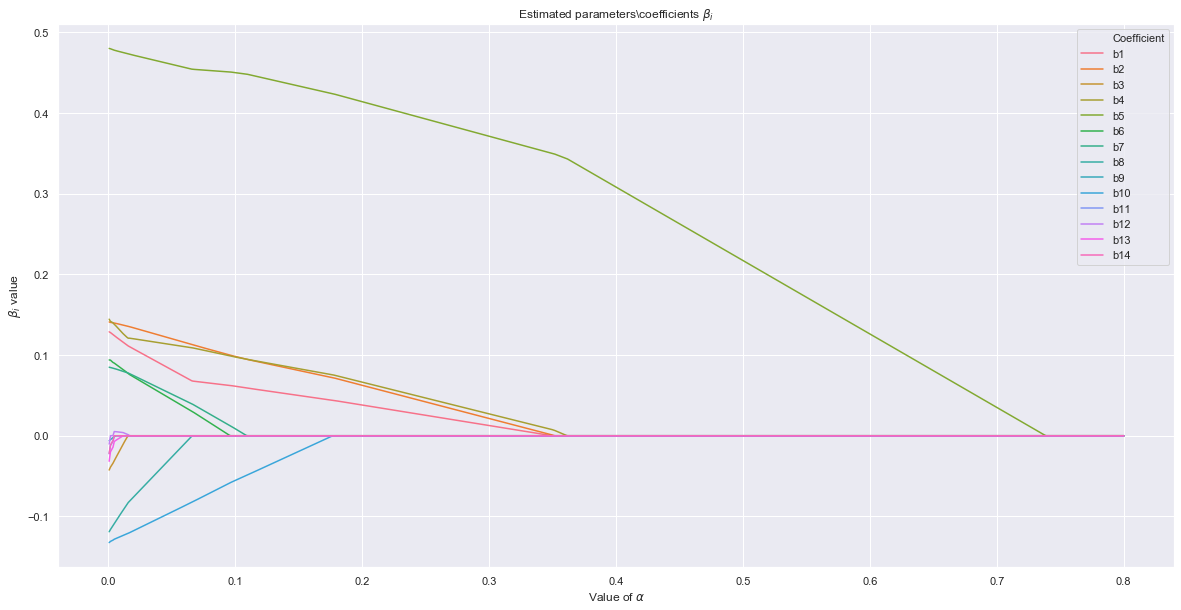

In [100]:
X = telco_df_norm_dummy.copy().drop(columns=['tenure'])
Y = telco_df_norm_dummy.copy().tenure

# lambdas = [0.9, 0.5, 0.25, 0.1, 0.01, 0.001, 0.0001]
lambdas = np.arange(0.8, 0, -0.001)
coefficients = []

for lambd in lambdas:
    X_train,X_test,Y_train,Y_test=model_selection.train_test_split(X,Y, test_size=0.3, random_state=7)

    lasso = linear_model.Lasso(alpha=lambd)
    lasso.fit(X_train,Y_train)
    train_score=lasso.score(X_train,Y_train)
    test_score=lasso.score(X_test,Y_test)
    coeff_used = np.sum(lasso.coef_!=0)
    coefficients.append(lasso.coef_)

    print("For alpha=%.5f" %lambd)
    print("Training score: %.5f" %train_score )
    print("Test score: %.5f" %test_score)
    print("Number of features used: %s \n" %coeff_used)
    

coefficients_df = pd.DataFrame(coefficients, columns=["b1", "b2", "b3", "b4", "b5", "b6", "b7", "b8", "b9", "b10", "b11", "b12", "b13", "b14"])
coefficients_df['alpha'] = lambdas
coefficients_df = coefficients_df.melt(id_vars=['alpha'], var_name='Coefficient')
coefficients_df.tail()

plt.figure(figsize=(20,10))
ax = sns.lineplot(x="alpha", y="value", hue="Coefficient", data=coefficients_df, )
# sns.lineplot(x=alphas, y="b2", data=coefficients_df)
# sns.lineplot(x=alphas, y="b3", data=coefficients_df)
plt.title("Estimated parameters\coefficients $\\beta_i$")
plt.ylabel("$\\beta_i$ value")
plt.xlabel("Value of $\\alpha$")
plt.show()

From this plot and printed test errors we could see that more or less accuracy of 61% achieved around $\lambda = 0.03$ so it make sense to recommend this value. Also with this values of $\lambda$ there is only 8 non-zero features coefficients and others are zeroed out. Now I would try to find optimal values of $\lambda$ by cross-validation.

In [102]:
X = telco_df_norm_dummy.copy().drop(columns=['tenure'])
Y = telco_df_norm_dummy.copy().tenure

lassoCV = linear_model.LassoCV(cv=15, random_state=7)
lassoCV.fit(X, Y)

print("Final score of CV: %.5f" %lassoCV.score(X, Y))
print("Optimal value of found by CV lambda = %.5f" %lassoCV.alpha_)
print("Optimal coefficients found by CV: %s" %lassoCV.coef_.round(5))

Final score of CV: 0.62021
Optimal value of found by CV lambda = 0.01162
Optimal coefficients found by CV: [ 0.09673  0.1427  -0.       0.11734  0.51164  0.05954  0.06464 -0.08162
 -0.0027  -0.1452  -0.00884  0.      -0.      -0.     ]


Optimal value of $\lambda$ found by Cross Validation is $\lambda=0.01162$.

## Subtask 2.

A nonlinear regression oﬀers a ﬂexible technique for modelling complex relationships. We wish to explain the "tenure" by the long distance calls per month "longmon". <br>

### Part (a)

Make a bivariate scatter plot and estimate an appropriate linear model. Add the regression line to the plot. 

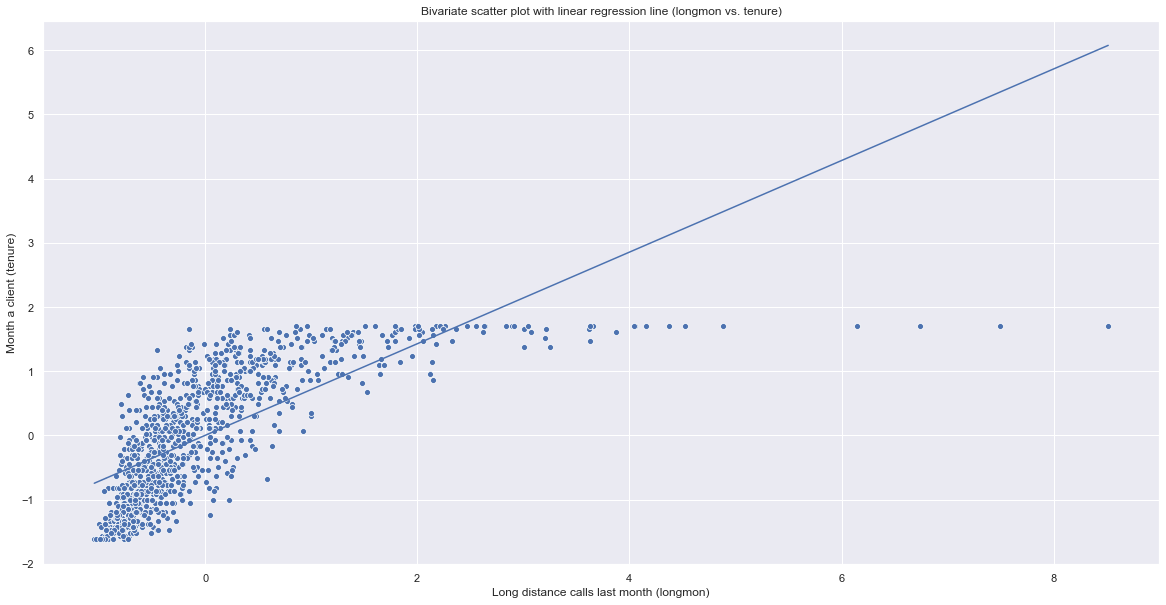

In [118]:
X = telco_df_norm_dummy.copy().longmon
X = sm.add_constant(X)
Y = telco_df_norm_dummy.copy().tenure

result = sm.OLS(Y , X).fit()
result.summary()

Y_pred_man = np.dot(X, result.params)

plt.figure(figsize=(20,10))
sns.scatterplot(x=telco_df_norm_dummy.longmon, y=telco_df_norm_dummy.tenure)
sns.lineplot(x=telco_df_norm_dummy.longmon, y=Y_pred_man)
plt.title("Bivariate scatter plot with linear regression line (longmon vs. tenure)")
plt.ylabel("Month a client (tenure)")
plt.xlabel("Long distance calls last month (longmon)")
plt.show()

### Part(b)

Estimate now an appropriate nonlinear regression which might ﬁt the data better. Add the regression curve to the plot and compare (quantitatively) the ﬁt with the ﬁt of the linear model. 

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


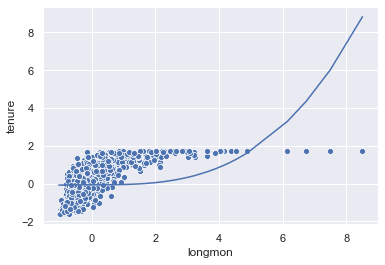

In [134]:
from sklearn.svm import SVR

X = telco_df_norm_dummy.copy().longmon
X = X.to_numpy().reshape(-1, 1)
Y = telco_df_norm_dummy.copy().tenure

model = SVR(kernel='poly')
model.fit(X,Y)

sns.scatterplot(x=telco_df_norm_dummy.longmon, y=telco_df_norm_dummy.tenure)
sns.lineplot(x=telco_df_norm_dummy.longmon, y=model.predict(X))